In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from pylab import *
import shutil

In [3]:
train = pd.read_csv(os.path.join('data', 'train.csv'))
test = pd.read_csv(os.path.join('data', 'test.csv'))
print("Information about the data")
print(train.info())

Information about the data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
None


How many have survived?
0    0.616162
1    0.383838
Name: Survived, dtype: float64


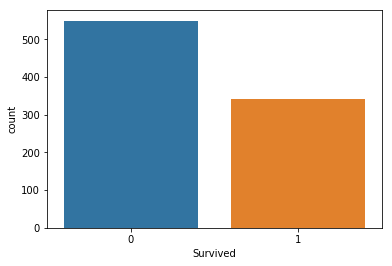

In [4]:
%matplotlib inline
print("How many have survived?")
print(train.Survived.value_counts(normalize=True))
count_plot = sns.countplot(train.Survived)
count_plot.get_figure().savefig("survived_count.png")

In [5]:
train['Name_Title'] = train['Name'].apply(lambda x: x.split(',')[1]).apply(lambda x: x.split()[0])
print('Title count')
print(train['Name_Title'].value_counts())
print('Survived by title')
print(train['Survived'].groupby(train['Name_Title']).mean())

Title count
Mr.          517
Miss.        182
Mrs.         125
Master.       40
Dr.            7
Rev.           6
Major.         2
Col.           2
Mlle.          2
Lady.          1
Sir.           1
Ms.            1
Don.           1
the            1
Capt.          1
Jonkheer.      1
Mme.           1
Name: Name_Title, dtype: int64
Survived by title
Name_Title
Capt.        0.000000
Col.         0.500000
Don.         0.000000
Dr.          0.428571
Jonkheer.    0.000000
Lady.        1.000000
Major.       0.500000
Master.      0.575000
Miss.        0.697802
Mlle.        1.000000
Mme.         1.000000
Mr.          0.156673
Mrs.         0.792000
Ms.          1.000000
Rev.         0.000000
Sir.         1.000000
the          1.000000
Name: Survived, dtype: float64


In [6]:
train['Name_Len'] = train['Name'].apply(lambda x: len(x))
print('Survived by name length')
print(train['Survived'].groupby(pd.qcut(train['Name_Len'],5)).mean())

Survived by name length
Name_Len
(11.999, 19.0]    0.220588
(19.0, 23.0]      0.301282
(23.0, 27.0]      0.319797
(27.0, 32.0]      0.442424
(32.0, 82.0]      0.674556
Name: Survived, dtype: float64


In [7]:
print('Survived by sex')
print(train['Survived'].groupby(train['Sex']).mean())

Survived by sex
Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64


In [8]:
train['Cabin_Letter'] = train['Cabin'].apply(lambda x: str(x)[0])
print('Survived by Cabin_Letter')
print(train['Survived'].groupby(train['Cabin_Letter']).mean())

Survived by Cabin_Letter
Cabin_Letter
A    0.466667
B    0.744681
C    0.593220
D    0.757576
E    0.750000
F    0.615385
G    0.500000
T    0.000000
n    0.299854
Name: Survived, dtype: float64


Survived by Embarked
Embarked
C    0.553571
Q    0.389610
S    0.336957
Name: Survived, dtype: float64


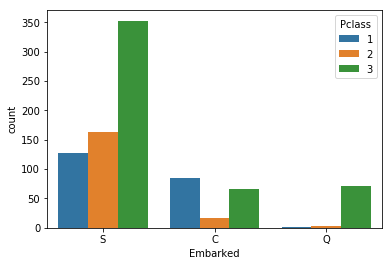

In [9]:
print('Survived by Embarked')
print(train['Survived'].groupby(train['Embarked']).mean())
count_plot = sns.countplot(train['Embarked'], hue=train['Pclass'])
count_plot.get_figure().savefig("survived_count_by_embarked.png")

Feature engineering

In [10]:
def create_name_feat(train, test):
    for i in [train, test]:
        i['Name_Len'] = i['Name'].apply(lambda x: len(x))
        i['Name_Title'] = i['Name'].apply(lambda x: x.split(',')[1]).apply(lambda x: x.split()[0])
        del i['Name']
    return train, test

In [11]:
def age_impute(train, test):
    for i in [train, test]:
        i['Age_Null_Flag'] = i['Age'].apply(lambda x: 1 if pd.isnull(x) else 0)
        data = train.groupby(['Name_Title', 'Pclass'])['Age']
        i['Age'] = data.transform(lambda x: x.fillna(x.mean()))
    return train, test

In [12]:
def fam_size(train, test):
    for i in [train, test]:
        i['Fam_Size'] = np.where((i['SibSp']+i['Parch']) == 0, 'One',
                                 np.where((i['SibSp']+i['Parch']) <= 3,'Small', 'Big'))
        del i['SibSp']
        del i['Parch']
    return train, test

In [13]:
def ticket_grouped(train, test):
    for i in [train, test]:
        i['Ticket_Letr'] = i['Ticket'].apply(lambda x: str(x)[0])
        i['Ticket_Letr'] = i['Ticket_Letr'].apply(lambda x: str(x))
        i['Ticket_Letr'] = np.where((i['Ticket_Letr']).isin(['1', '2','3', 'S', 'P', 'C', 'A']),
                                    i['Ticket_Letr'],np.where((i['Ticket_Letr']).
                                                              isin(['W', '4', '7', '6', 'L', '5', '8']),'Low_ticket', 'Other_ticket'))
        i['Ticket_Len'] = i['Ticket'].apply(lambda x: len(x))
        del i['Ticket']
    return train, test

In [14]:
def cabin(train, test):
    for i in [train, test]:
        i['Cabin_Letter'] = i['Cabin'].apply(lambda x: str(x)[0])
        del i['Cabin']
    return train, test

In [15]:
def embarked_impute(train, test):
    for i in [train, test]:
        i['Embarked'] = i['Embarked'].fillna('S')
    return train, test

In [16]:
def dummies(train, test, columns = ['Pclass', 'Sex', 'Embarked', 'Ticket_Letr', 
                                    'Cabin_Letter', 'Name_Title', 'Fam_Size']):
    for column in columns:
        train[column] = train[column].apply(lambda x: str(x))
        test[column] = test[column].apply(lambda x: str(x))
        good_cols = [column+'_'+i for i in train[column].unique() if i in test[column].unique()]
        train = pd.concat((train, pd.get_dummies(train[column], prefix=column)[good_cols]), axis=1)
        test = pd.concat((test, pd.get_dummies(test[column], prefix=column)[good_cols]), axis=1)
        del train[column]
        del test[column]
    return train, test

In [17]:
def PrepareTarget(data):
    return np.array(data.Survived, dtype='int8').reshape(-1, 1)

Logistic regression for survival prediction

In [18]:
import os
import shutil
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from feature import *
import tensorflow as tf
from tensorflow.contrib.learn.python.learn.estimators import estimator
from tensorflow.contrib import learn
from tensorflow.python.framework import ops

In [19]:
random.seed(1985)
train = pd.read_csv(os.path.join('data', 'train.csv'))
test = pd.read_csv(os.path.join('data', 'test.csv'))

In [20]:
train, test = create_name_feat(train, test)
print(train.head())
train, test = age_impute(train, test)
train, test = cabin(train, test)
train, test = embarked_impute(train, test)
train, test = fam_size(train, test)
test['Fare'].fillna(train['Fare'].mean(), inplace=True)
train, test = ticket_grouped(train, test)

   PassengerId  Survived  Pclass     Sex   Age  SibSp  Parch  \
0            1         0       3    male  22.0      1      0   
1            2         1       1  female  38.0      1      0   
2            3         1       3  female  26.0      0      0   
3            4         1       1  female  35.0      1      0   
4            5         0       3    male  35.0      0      0   

             Ticket     Fare Cabin Embarked  Name_Len Name_Title  
0         A/5 21171   7.2500   NaN        S        23        Mr.  
1          PC 17599  71.2833   C85        C        51       Mrs.  
2  STON/O2. 3101282   7.9250   NaN        S        22      Miss.  
3            113803  53.1000  C123        S        44       Mrs.  
4            373450   8.0500   NaN        S        24        Mr.  


In [21]:
train, test = dummies(train, test, columns=['Pclass', 'Sex', 'Embarked', 
                                            'Ticket_Letr', 'Cabin_Letter', 'Name_Title', 'Fam_Size'])

In [22]:
TEST = True
if TEST:
    train, test = train_test_split(train, test_size=0.2, random_state=10)
    train = train.sort_values('PassengerId')
    test = test.sort_values('PassengerId')
train['PassengerId'] = train['PassengerId'].astype(str)
test['PassengerId'] = test['PassengerId'].astype(str)
x_train = train.iloc[:, 1:]
x_test = test.iloc[:, 1:]

In [23]:
x_train = np.array(x_train.iloc[:, 1:], dtype='float32')
if TEST:
    x_test = np.array(x_test.iloc[:, 1:], dtype='float32')
else:
    x_test = np.array(x_test, dtype='float32')

In [24]:
y_train = PrepareTarget(train)

In [25]:
feature_count = x_train.shape[1]

In [26]:
def build_lr_estimator(model_dir, feature_count):
    return estimator.SKCompat(learn.LinearClassifier(
        feature_columns=[tf.contrib.layers.real_valued_column("", dimension=feature_count)],
        n_classes=2, model_dir=model_dir))

In [27]:
print("Training...")
try:
    shutil.rmtree('lr/')
except OSError:
    pass
lr = build_lr_estimator('lr/', feature_count)
lr.fit(x_train, y_train, steps=100)
lr_pred = lr.predict(x_test)
lr_pred = lr_pred['classes']

Training...
Instructions for updating:
Please switch to tf.contrib.estimator.*_head.
Instructions for updating:
Please replace uses of any Estimator from tf.contrib.learn with an Estimator from tf.estimator.*
Instructions for updating:
When switching to tf.estimator.Estimator, use tf.estimator.RunConfig instead.
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000000009815198>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_train_distribute': None, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_log_step_count_steps': 100, '_session_config': None, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_model_dir'

In [28]:
if TEST:
    target_names = ['Not Survived', 'Survived']

    print("Logistic Regression Report")
    print(classification_report(test['Survived'], lr_pred, target_names=target_names))
    print("Logistic Regression Confusion Matrix")

Logistic Regression Report
              precision    recall  f1-score   support

Not Survived       0.90      0.81      0.86       117
    Survived       0.70      0.84      0.76        62

 avg / total       0.83      0.82      0.82       179

Logistic Regression Confusion Matrix


In [29]:
if TEST:
    target_names = ['Not Survived', 'Survived']

    print("Logistic Regression Report")
    print(classification_report(test['Survived'], lr_pred, target_names=target_names))
    print("Logistic Regression Confusion Matrix")
    cm = confusion_matrix(test['Survived'], lr_pred)
    df_cm = pd.DataFrame(cm, index=[i for i in ['Not Survived', 'Survived']],
                         columns=[i for i in ['Not Survived', 'Survived']])
    print(df_cm)

Logistic Regression Report
              precision    recall  f1-score   support

Not Survived       0.90      0.81      0.86       117
    Survived       0.70      0.84      0.76        62

 avg / total       0.83      0.82      0.82       179

Logistic Regression Confusion Matrix
              Not Survived  Survived
Not Survived            95        22
Survived                10        52


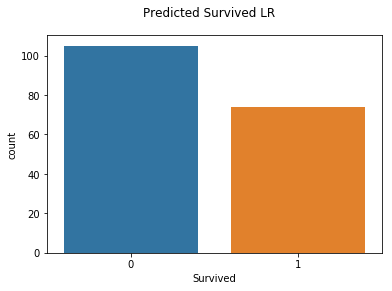

In [30]:
sol = pd.DataFrame()
sol['PassengerId'] = test['PassengerId']
sol['Survived'] = pd.Series(lr_pred.reshape(-1)).map({True:1, False:0}).values
sol.to_csv('submission_lr.csv', index=False)
plt.suptitle("Predicted Survived LR")
count_plot = sns.countplot(sol.Survived)
count_plot.get_figure().savefig("survived_count_lr_prd.png")

In [31]:
print("Predicted Counts")
print(sol.Survived.value_counts())

Predicted Counts
0    105
1     74
Name: Survived, dtype: int64


Linear SVM for survival prediction

In [32]:
import os
import shutil
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from feature import *
import tensorflow as tf
from tensorflow.contrib.learn.python.learn.estimators import svm
from tensorflow.python.framework import ops

In [33]:
random.seed(1985)
train = pd.read_csv(os.path.join('data', 'train.csv'))
test = pd.read_csv(os.path.join('data', 'test.csv'))

train, test = create_name_feat(train, test)
train, test = age_impute(train, test)
train, test = cabin(train, test)
train, test = embarked_impute(train, test)
train, test = fam_size(train, test)
test['Fare'].fillna(train['Fare'].mean(), inplace=True)
train, test = ticket_grouped(train, test)

train, test = dummies(train, test, columns=['Pclass', 'Sex', 'Embarked', 'Ticket_Letr', 'Cabin_Letter', 'Name_Title', 'Fam_Size'])

TEST = True
if TEST:
    train, test = train_test_split(train, test_size=0.2, random_state=10)
    train = train.sort_values('PassengerId')
    test = test.sort_values('PassengerId')

train['PassengerId'] = train['PassengerId'].astype(str)
test['PassengerId'] = test['PassengerId'].astype(str)

In [34]:
def train_input_fn():
    continuous_cols = {k: tf.expand_dims(tf.constant(train[k].values), 1)
                       for k in list(train) if k not in ['Survived', 'PassengerId']}
    id_col = {'PassengerId' : tf.constant(train['PassengerId'].values)}
    feature_cols = continuous_cols.copy()
    feature_cols.update(id_col)
    label = tf.constant(train["Survived"].values)
    return feature_cols, label

In [35]:
def predict_input_fn():
    continuous_cols = {k: tf.expand_dims(tf.constant(test[k].values), 1)
                       for k in list(test) if k not in ['Survived', 'PassengerId']}
    id_col = {'PassengerId' : tf.constant(test['PassengerId'].values)}
    feature_cols = continuous_cols.copy()
    feature_cols.update(id_col)
    return feature_cols

In [36]:
try:
    shutil.rmtree('svm/')
except OSError:
    pass
svm_model = svm.SVM(example_id_column="PassengerId",
                    feature_columns=[tf.contrib.layers.real_valued_column(k) for k in list(train)
                                     if k not in ['Survived', 'PassengerId']],
                    model_dir="svm/")
svm_model.fit(input_fn=train_input_fn, steps=100)
svm_pred = list(svm_model.predict_classes(input_fn=predict_input_fn))

Instructions for updating:
Please switch to tf.contrib.estimator.*_head.
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000000013A14860>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_train_distribute': None, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_log_step_count_steps': 100, '_session_config': None, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': 'svm/'}
INFO:tensorflow:Created variable linear/bias_weight:0, with device=
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.

In [37]:
if TEST:
    target_names = ['Not Survived', 'Survived']
    print("SVM Report")
    print(classification_report(test['Survived'], svm_pred, target_names=target_names))

SVM Report
              precision    recall  f1-score   support

Not Survived       0.89      0.84      0.86       117
    Survived       0.72      0.81      0.76        62

 avg / total       0.83      0.83      0.83       179



In [38]:
if TEST:
    target_names = ['Not Survived', 'Survived']
    print("SVM Report")
    print(classification_report(test['Survived'], svm_pred, target_names=target_names))

    print("SVM Confusion Matrix")
    cm = confusion_matrix(test['Survived'], svm_pred)
    df_cm = pd.DataFrame(cm, index=[i for i in ['Not Survived', 'Survived']],
                         columns=[i for i in ['Not Survived', 'Survived']])
    print(df_cm)

SVM Report
              precision    recall  f1-score   support

Not Survived       0.89      0.84      0.86       117
    Survived       0.72      0.81      0.76        62

 avg / total       0.83      0.83      0.83       179

SVM Confusion Matrix
              Not Survived  Survived
Not Survived            98        19
Survived                12        50


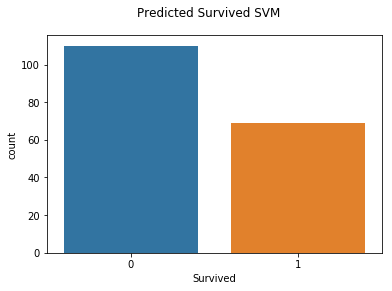

In [39]:
sol = pd.DataFrame()
sol['PassengerId'] = test['PassengerId']
sol['Survived'] = pd.Series(svm_pred).values
sol.to_csv('submission_svm.csv', index=False)
plt.suptitle("Predicted Survived SVM")
count_plot = sns.countplot(sol.Survived)
count_plot.get_figure().savefig("survived_count_svm_prd.png")

In [40]:
print("Predicted Counts")
print(sol.Survived.value_counts())

Predicted Counts
0    110
1     69
Name: Survived, dtype: int64


Ensemble method for survival prediction

In [41]:
import os
import shutil
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from feature import *

import tensorflow as tf
from tensorflow.contrib.learn.python.learn.estimators import estimator
from tensorflow.contrib.tensor_forest.client import random_forest
from tensorflow.contrib.tensor_forest.python import tensor_forest

from tensorflow.python.framework import ops

In [42]:
random.seed(1985)

def build_rf_estimator(model_dir, feature_count):
    params = tensor_forest.ForestHParams(
        num_classes=2,
        num_features=feature_count,
        num_trees=1000,
        max_nodes=1000,
        min_split_samples=10)
    
    graph_builder_class = tensor_forest.RandomForestGraphs
    return estimator.SKCompat(random_forest.TensorForestEstimator(
        params, graph_builder_class=graph_builder_class,
        model_dir=model_dir))

In [43]:
train = pd.read_csv(os.path.join('input', 'train.csv'))
test = pd.read_csv(os.path.join('input', 'test.csv'))

train, test = create_name_feat(train, test)
train, test = age_impute(train, test)
train, test = cabin(train, test)
train, test = embarked_impute(train, test)
train, test = fam_size(train, test)
test['Fare'].fillna(train['Fare'].mean(), inplace=True)
train, test = ticket_grouped(train, test)

train, test = dummies(train, test, columns=['Pclass', 'Sex', 'Embarked', 'Ticket_Letr', 'Cabin_Letter', 'Name_Title', 'Fam_Size'])

TEST = True
if TEST:
    train, test = train_test_split(train, test_size=0.2, random_state=10)
    train = train.sort_values('PassengerId')
    test = test.sort_values('PassengerId')

train['PassengerId'] = train['PassengerId'].astype(str)
test['PassengerId'] = test['PassengerId'].astype(str)

x_train = train.iloc[:, 1:]
x_test = test.iloc[:, 1:]

x_train = np.array(x_train.iloc[:, 1:], dtype='float32')
if TEST:
    x_test = np.array(x_test.iloc[:, 1:], dtype='float32')
else:
    x_test = np.array(x_test, dtype='float32')

y_train = PrepareTarget(train)
feature_count = x_train.shape[1]

print(x_train.shape)
print(x_test.shape)

print("Training...")

try:
    shutil.rmtree('rf/')
except OSError:
    pass


(712, 41)
(179, 41)
Training...


In [44]:
rf = build_rf_estimator('rf/', feature_count)
rf.fit(x_train, y_train, batch_size=50)
rf_pred = rf.predict(x_test)
rf_pred = rf_pred['classes']

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x00000000177E5C88>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_train_distribute': None, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_log_step_count_steps': 100, '_session_config': None, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': 'rf/'}
INFO:tensorflow:Constructing forest with params = 
INFO:tensorflow:{'num_trees': 1000, 'max_nodes': 1000, 'bagging_fraction': 1.0, 'feature_bagging_fraction': 1.0, 'num_splits_to_consider': 10, 'max_fertile_nodes': 0, 'split_after_samples': 250, 'valid_leaf_threshold': 1, 'dominate_method': 'bootstrap', 

In [45]:
target_names = ['Not Survived', 'Survived']
print("RandomForest Report")
print(classification_report(test['Survived'], rf_pred, target_names=target_names))

RandomForest Report
              precision    recall  f1-score   support

Not Survived       0.90      0.88      0.89       117
    Survived       0.78      0.82      0.80        62

 avg / total       0.86      0.86      0.86       179



In [46]:
print("Random Forest Confusion Matrix")
cm = confusion_matrix(test['Survived'], rf_pred)
df_cm = pd.DataFrame(cm, index=[i for i in ['Not Survived','Survived']],
                     columns=[i for i in ['Not Survived','Survived']])
print(df_cm)

Random Forest Confusion Matrix
              Not Survived  Survived
Not Survived           103        14
Survived                11        51


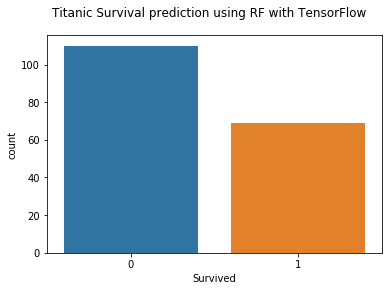

In [47]:
sol = pd.DataFrame()
sol['PassengerId'] = test['PassengerId']
sol['Survived'] = pd.Series(svm_pred).values
plt.suptitle("Titanic Survival prediction using RF with TensorFlow")
count_plot = sns.countplot(sol.Survived)

In [48]:
print("Predicted Counts")
print(sol.Survived.value_counts())

Predicted Counts
0    110
1     69
Name: Survived, dtype: int64
